# <span style='color:blue'> General analysis of data</span>

The present `Jupyter Notebook` contains the global analysis of activity data and structural similarity for the group of   BTZs synthesized at the Leibniz-HKI. 

## Import Essentials

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

from sklearn.manifold import MDS

from rdkit.Chem import Descriptors
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs


In [2]:
# Import functions from customized module
from Scripts.preprocessing import create_mol

## Define file names and colors

In [3]:
# File names and sheet names
descriptors_file = './Data/BTZs_full_descriptors_final.xlsx'
data_matrix = 'general_data_matrix'

# Colors
colors1 = ['#eff3ff', '#c6dbef', '#9ecae1', '#6baed6', '#3182bd', '#08519c']
colors2 = ['#d7191c', '#2c7bb6']

# Define a customized colormap 
cmap = LinearSegmentedColormap.from_list('', colors1)

## Load data  

These descriptors were calculated in the Schrödinger Suite and exported as a csv file.

In [4]:
# Load excel spreadsheet
BTZs = pd.read_excel(descriptors_file, sheet_name=data_matrix)

In [5]:
BTZs

,ID_Paper,Code,Smiles,MIC[M],pMIC,Class,Group
0,32,SSN2785,OC(C(C=CC=C1)=C1N2CCN(C3=NC(C4=C(C([N+]([O-])=...,6.494342e-06,5.187465,0,3
1,31,SSN2791,CC(C(C=C1)=CC=C1N2CCN(C3=NC(C4=C(C([N+]([O-])=...,1.295861e-07,6.887441,0,3
2,35,SSN2792,COC1=CC(OC)=CC(N2CCN(C3=NC(C4=C(C([N+]([O-])=O...,6.244194e-08,7.204524,1,3
3,34,SSN2793,O=C1C2=C(C([N+]([O-])=O)=CC(C(F)(F)F)=C2)SC(N3...,3.467563e-08,7.459976,1,3
4,33,SSN2794,O=C1C2=C(C([N+]([O-])=O)=CC(C(F)(F)F)=C2)SC(N3...,8.668907e-09,8.062036,1,3
...,...,...,...,...,...,...,...
91,73,TFK-040,O=C1C2=C(C([N+]([O-])=O)=CC(C(F)(F)F)=C2)SC(N3...,1.053922e-04,3.977191,0,4
92,88,TFK-052,O=C1C2=C(C([N+]([O-])=O)=CC(C(F)(F)F)=C2)SC(NC...,6.137572e-05,4.212003,0,6
93,24,TFK-057,O=C1C2=C(C([N+]([O-])=O)=CC(C(F)(F)F)=C2)SC(N3...,6.590200e-06,5.181101,0,2
94,80,TFK-072,O=C1C2=C(C([N+]([O-])=O)=CC(C(F)(F)F)=C2)SC(N3...,1.360461e-05,4.866314,0,5


In [6]:
# Create new dataframe from BTZs
BTZs_morgan = BTZs.copy()
# Apply create_mol to calculate Morgan fingerprints 
create_mol(BTZs_morgan, 'ecfp4', n_bits=2048)

In [7]:
BTZs_rdkit = BTZs.copy()
# Apply create_mol
create_mol(BTZs_rdkit, 'rdk5', n_bits=2048)

## Activity distributions

In order to get a global insight into the activity distributions, construction of kernel density distributions plots was attempted (using Seaborn). 

<AxesSubplot:xlabel='Group', ylabel='pMIC'>

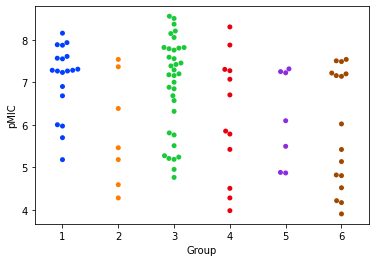

In [8]:
# Plot distributions using a swarm plot
sns.swarmplot(x='Group', y='pMIC', data=BTZs, palette=sns.color_palette('bright', n_colors=6))

The results were then better observed as distributions using kernel density estimation

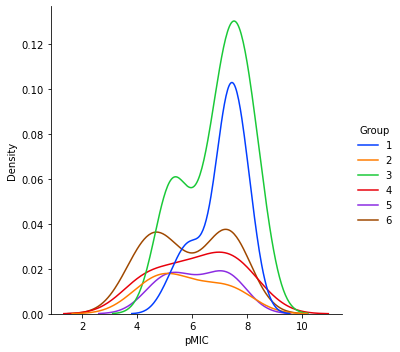

In [9]:
# Plot distributions using kde obtained from Seaborn functionality
sns.displot(data=BTZs, x='pMIC', hue='Group', kind='kde', palette=sns.color_palette('bright', n_colors=6))

In [10]:
print('Maximum IC50: {} uM'.format(np.round((10 ** -BTZs.pMIC.min()) * 1e6, 2)))

Maximum IC50: 125.84 uM


In [11]:
print('Minimum IC50: {} nM'.format(np.round((10 ** -BTZs.pMIC.max()) * 1e9, 2)))

Minimum IC50: 2.74 nM


## Further analysis of groups 1 and 3

In [12]:
# Add mol object to dataframe
BTZs['mol'] = BTZs.Smiles.apply(Chem.MolFromSmiles)

In [13]:
# Retrieve only data for group 1
data_group1 = BTZs[BTZs.Group==1]
data_group1.shape

(19, 8)

In [14]:
# Calculate fingerprints for Tanimoto
fp1 = [AllChem.GetMorganFingerprint(x, 2) for x in data_group1.mol]

# Generate Similarity matrix using compound with activity equal to the median of the group as reference
qu1, sim1, da1, aa1 = [], [], [], []
ref_idx1 = data_group1.ID_Paper.to_list().index('18a') # compound 18a used as reference
# ref = 10
for i in range(len(fp1)):
    if i != ref_idx1:
        s = DataStructs.TanimotoSimilarity(fp1[ref_idx1], fp1[i])
        qu1.append(data_group1.ID_Paper.values[i])
        sim1.append(s)
        da1.append(data_group1.pMIC.values[i] - data_group1.pMIC.values[ref_idx1])
        aa1.append(data_group1.pMIC.values[i])

In [15]:
# Store in dataframe
d1 = {'query_ID': qu1, 'Similarity': sim1, 'Delta_activity': da1, 'Activity': aa1}
df_group1 = pd.DataFrame(data=d1)
# Order dataframes by similarity
df_group1.sort_values(by='Similarity', inplace=True)

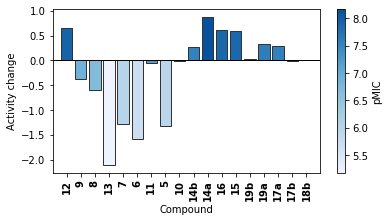

In [16]:
# Define x
x = np.arange(len(df_group1))
# Define rescaling
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

# Create figure object and store it in a variable called 'fig'
fig = plt.figure(figsize=(6, 3))

# Add axes object to our figure 
ax = fig.add_subplot(111)

# Create bar plot and add line at y = 0
ax.bar(x, df_group1.Delta_activity,  
       color=cmap(rescale(df_group1.Activity)),
       edgecolor=[0.2, 0.2, 0.2])
ax.axhline(y=0, linewidth=1, color='k')

ax.set_xlabel('Compound')
ax.set_ylabel('Activity change')
ax.set_xticks(x)
ax.set_xlim(-1, 18)
ax.set_xticklabels(df_group1.query_ID, rotation=90, fontweight='bold')

# Add colorbar
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(df_group1.Activity.min(),df_group1.Activity.max()))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('pMIC', rotation=90)

plt.show()

In [17]:
# Retrieve data only for group 3
data_group3 = BTZs[BTZs.Group==3]
data_group3.shape

(35, 8)

In [18]:
# Calculate fingerprints for Tanimoto
fp3 = [AllChem.GetMorganFingerprint(x, 2) for x in data_group3.mol]

# Generate Similarity matrix using compound with activity equal to the median of the group as reference
qu3, sim3, da3, aa3 = [], [], [], []
ref_idx3 = data_group3.ID_Paper.to_list().index(35) # compound 35 used as reference
# ref = 10
for i in range(len(fp3)):
    if i != ref_idx3:
        s = DataStructs.TanimotoSimilarity(fp3[ref_idx3], fp3[i])
        qu3.append(data_group3.ID_Paper.values[i])
        sim3.append(s)
        da3.append(data_group3.pMIC.values[i] - data_group3.pMIC.values[ref_idx3])
        aa3.append(data_group3.pMIC.values[i])

In [19]:
# Store in dataframe
d3 = {'query_ID': qu3, 'Similarity': sim3, 'Delta_activity': da3, 'Activity': aa3}
df_group3 = pd.DataFrame(data=d3)
# Order dataframes by similarity
df_group3.sort_values(by='Similarity', inplace=True)

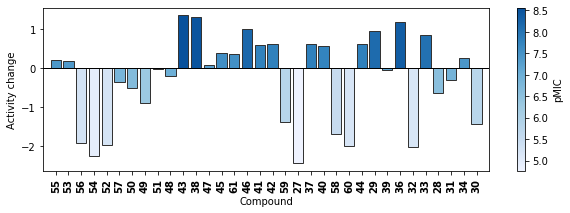

In [20]:
# Define x
x = np.arange(len(df_group3))
# Define rescaling
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

# Create figure object and store it in a variable called 'fig'
fig = plt.figure(figsize=(10, 3))

# Add axes object to our figure 
ax = fig.add_subplot(111)

# Create bar plot and add line at y = 0
ax.bar(x, df_group3.Delta_activity,  
       color=cmap(rescale(df_group3.Activity)),
       edgecolor=[0.2, 0.2, 0.2])
ax.axhline(y=0, linewidth=1, color='k')

ax.set_xlabel('Compound')
ax.set_ylabel('Activity change')
ax.set_xticks(x)
ax.set_xlim(-1, 34)
ax.set_xticklabels(df_group3.query_ID, rotation=90, fontweight='bold')

# Add colorbar
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(df_group3.Activity.min(), df_group3.Activity.max()))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('pMIC', rotation=90, labelpad=5)

plt.show()

## TPSA and LogP

Now, a simple analysis of TPSA and cLogP was carried. Those descriptors were calculated using RDKit.

In [21]:
# Independent calculation of each descriptor
logP = [Descriptors.MolLogP(x) for x in BTZs.mol.values]
TPSA = [Descriptors.TPSA(x) for x in BTZs.mol.values]

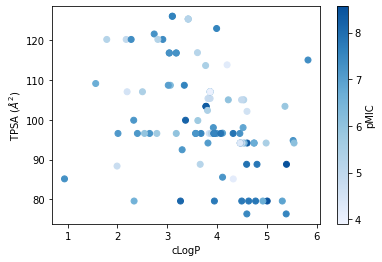

In [22]:
# Create figure object and store it in a variable called 'fig'
fig = plt.figure()

# Add axes object to our figure 
ax = fig.add_subplot(111)

# Create plot
ax.scatter(logP, TPSA, c=BTZs.pMIC, cmap=cmap)

# Edit axes
ax.set_xlabel('cLogP')
ax.set_ylabel(r'TPSA ($\AA^{2}$)')

sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(BTZs.pMIC.min(), BTZs.pMIC.max()))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('pMIC', rotation=90)

plt.show()


## Presence of Functional Groups

In [23]:
# define patterns to search for using smarts strings
smart_patterns = {
'phenol': Chem.MolFromSmarts('[OX2H][cX3]:[c]'),
'alcohol': Chem.MolFromSmarts('[#6][OX2H]'),
'amide': Chem.MolFromSmarts('[NX3][CX3](=[OX1])[#6]'),
'carbonyl': Chem.MolFromSmarts('[CX3]=[OX1]'),
'acid': Chem.MolFromSmarts('[CX3](=O)[OX2H1]'),
'amine': Chem.MolFromSmarts('[N&X3;H2,H1;!$(NC=*)]')
}

# Run search and store results in dataframe
matches = pd.DataFrame(columns=['mol', 'match', 'Class'])
for i, mol in enumerate(BTZs.mol.values):
    for key, patt in smart_patterns.items():
        if mol.HasSubstructMatch(patt):
            matches.loc[len(matches)] = [mol, key, BTZs.Class.values[i]]
            
matches.shape

(73, 3)

In [24]:
# Define labels for functional groups
labels = ['phenol', 'alcohol', 'amide', 'carbonyl', 'acid', 'amine']

# Separate samples into actives and inactives
inac = matches.match[matches.Class == 0].value_counts()
ac = matches.match[matches.Class == 1].value_counts()

# Create dataframe with information for plotting
matches_plot = pd.DataFrame(columns=['inactives', 'actives'], index=labels)
for lab in labels:
    if lab in inac.index:
        val0 = inac[lab]
    else:
        val0 = 0
    if lab in ac.index:
        val1 = ac[lab]
    else:
        val1 = 0
        
    matches_plot.loc[lab] = [val0, val1]

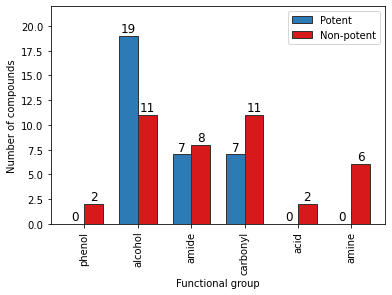

In [25]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Create figure object and store it in a variable called 'fig'
fig = plt.figure()

# Add axes object to our figure 
ax = fig.add_subplot(111)

# Create bar plots
rects2 = ax.bar(x - width/2, matches_plot.actives, width, label='Potent', 
                color=colors2[1], edgecolor=[0.2, 0.2, 0.2])
rects1 = ax.bar(x + width/2, matches_plot.inactives, width, label='Non-potent', 
                color=colors2[0], edgecolor=[0.2, 0.2, 0.2])


# Edit axes
ax.set_xlabel('Functional group')
ax.set_ylabel('Number of compounds')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylim((0, 22))

# Add text labels
for i in range(len(labels)):
    plt.text(x[i] + width/2, matches_plot.inactives.values[i] + 0.4, str(matches_plot.inactives.values[i]),
             fontsize=12, ha='center')
    plt.text(x[i] - width/2, matches_plot.actives.values[i] + 0.4, str(matches_plot.actives.values[i]),
             fontsize=12, ha='center')

ax.legend(bbox_to_anchor=(1, 1))

plt.show()

## Data mining 

#### Morgan Fingerprints

In [26]:
# Define fingerprints for calculation of Tanimoto distances
fps = BTZs_morgan.bv.to_list()

# Calculate Tanimoto distances
tan_dist = np.zeros((len(fps), len(fps)))
for i in range(len(fps)):
    for j in range(len(fps)):
        tan_dist[i , j] = 1 - DataStructs.TanimotoSimilarity(fps[i], fps[j])

In [27]:
# Run MDS

# Instantiate the model
mds = MDS(n_components=2, random_state=42, dissimilarity='precomputed')
# Apply dimensionality reduction
X_2d_tan = mds.fit_transform(tan_dist)

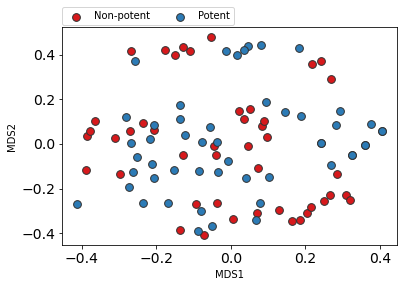

In [28]:
# Create figure object and store it in a variable called 'fig'
fig = plt.figure()

# Add axes object to our figure 
ax = fig.add_subplot(111)

# Create scatter plot
for group, color, label in zip([0, 1], colors2, ['Non-potent', 'Potent']):
    data = BTZs.copy()
    data.reset_index(drop=True, inplace=True)
    idx = data[data.Class == group].index    
    ax.scatter(X_2d_tan[idx, 0], X_2d_tan[idx, 1], c=color, 
               s=60, edgecolors=[0.2, 0.2, 0.2], label=label)

# Edit axes
ax.set_xlabel('MDS1')
ax.set_ylabel('MDS2')

ax.tick_params(axis='both', labelsize=14)
ax.legend(loc=(0, 1.01), ncol=2)

plt.show()


#### RDKit Fingerprints

In [29]:
# Define fingerprints for calculation of Tanimoto distances
fps = BTZs_rdkit.bv.to_list()

# Calculate Tanimoto distances   
tan_dist = np.zeros((len(fps), len(fps)))
for i in range(len(fps)):
    for j in range(len(fps)):
        tan_dist[i , j] = 1 - DataStructs.TanimotoSimilarity(fps[i], fps[j])

In [30]:
# Run MDS

# Instantiate the model
mds = MDS(n_components=2, random_state=42, dissimilarity='precomputed')
# Apply dimensionality reduction
X_2d_tan = mds.fit_transform(tan_dist)

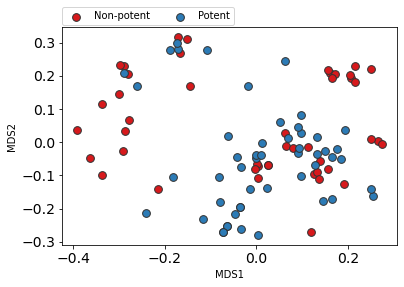

In [31]:
# Create figure object and store it in a variable called 'fig'
fig = plt.figure()

# Add axes object to our figure 
ax = fig.add_subplot(111)

# Create scatter plot
for group, color, label in zip([0, 1], colors2, ['Non-potent', 'Potent']):
    data = BTZs.copy()
    data.reset_index(drop=True, inplace=True)
    idx = data[data.Class == group].index    
    ax.scatter(X_2d_tan[idx, 0], X_2d_tan[idx, 1], c=color, 
               s=60, edgecolors=[0.2, 0.2, 0.2], label=label)

# Edit axes
ax.set_xlabel('MDS1')
ax.set_ylabel('MDS2')
#ax.set_xlim((-0.5, 0.5))
#ax.set_ylim((-0.5, 0.55))

ax.tick_params(axis='both', labelsize=14)
ax.legend(loc=(0, 1.01), ncol=2)

plt.show()
